In this notebook, we are looking for gaps in the audio data collected by two badges - one with an old firmware, and one with the new firmware (2.0)

New badge (firmware 2.0) - D4:E4:47:A5:F0:B3

Old badge - E7:00:28:A7:DB:C2

In [1]:
from __future__ import absolute_import, division, print_function

import os
import sys
import datetime
import pandas as pd
import numpy as np
import pytz
import dateutil
import gzip

from ggplot import *
%matplotlib inline

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, os.pardir)
sys.path.append(src_dir)

# import data analysis modules
import openbadge_analysis as ob

In [2]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
# list of modules to autoload
%aimport openbadge_analysis

In [3]:
filename = '/home/orenled/temp/logs/3_log_audio.txt.gz'
log_filename = '/home/orenled/temp/logs/3_server.log.gz'

# Filtering out gaps after the badge first reset

If we want to get a real sense of how many gaps we have, we need to discard data after the the badges stared to reset. We need to look at the actualy logfile to find that time. This isn't going to be pretty, but it will work.

In [4]:
with gzip.open(log_filename, 'r') as f:
    unsync_raw = [ line for line in f if 'unsync' in line]

In [5]:
import re
# use regex to get date and badge
unsync_split = [ re.match('(.*) - INFO - \[(.*)\]',line).group(1,2) for line in unsync_raw]

In [6]:
# load into a dataframe and convert the date
df_log = pd.DataFrame(unsync_split,columns=['datetime','badge_address'])
print(df_log.head())
print(df_log['datetime'].head())

                  datetime      badge_address
0  2016-12-27 11:51:55,113  C7:75:13:05:10:EE
1  2016-12-27 11:51:58,390  F9:4A:86:6E:F4:0C
2  2016-12-30 09:45:36,636  F9:4A:86:6E:F4:0C
3  2016-12-30 10:16:56,960  F9:4A:86:6E:F4:0C
4  2016-12-30 10:47:39,001  F9:4A:86:6E:F4:0C
0    2016-12-27 11:51:55,113
1    2016-12-27 11:51:58,390
2    2016-12-30 09:45:36,636
3    2016-12-30 10:16:56,960
4    2016-12-30 10:47:39,001
Name: datetime, dtype: object


In [7]:
df_log['datetime'] = pd.to_datetime(df_log['datetime'], utc=True)
df_log.sort_values('datetime')
df_log.index = pd.to_datetime(df_log.pop('datetime'), utc=True)

# this log is in EST, needs to convert do UTC
eastern = pytz.timezone('US/Eastern')
utc  = pytz.timezone('UTC')
df_log = df_log.tz_localize(eastern)
df_log = df_log.tz_convert(utc)
print(df_log.head())
print(df_log.index)

                                      badge_address
datetime                                           
2016-12-27 16:51:55.113000+00:00  C7:75:13:05:10:EE
2016-12-27 16:51:58.390000+00:00  F9:4A:86:6E:F4:0C
2016-12-30 14:45:36.636000+00:00  F9:4A:86:6E:F4:0C
2016-12-30 15:16:56.960000+00:00  F9:4A:86:6E:F4:0C
2016-12-30 15:47:39.001000+00:00  F9:4A:86:6E:F4:0C
DatetimeIndex(['2016-12-27 16:51:55.113000+00:00',
               '2016-12-27 16:51:58.390000+00:00',
               '2016-12-30 14:45:36.636000+00:00',
               '2016-12-30 15:16:56.960000+00:00',
               '2016-12-30 15:47:39.001000+00:00',
               '2016-12-30 16:49:16.291000+00:00',
               '2016-12-30 17:20:06.052000+00:00',
               '2016-12-30 17:50:50.442000+00:00',
               '2016-12-30 18:21:31.930000+00:00',
               '2016-12-30 20:24:03.063000+00:00',
               '2016-12-30 20:54:41.536000+00:00',
               '2016-12-30 21:25:21.014000+00:00',
               '2016-12-

In [8]:
# reseting index, now that we converted the timezone (i'm not sure how to do this more efficiently...)
df_log = df_log.reset_index()
print(df_log.head())
print(df_log.index)

                          datetime      badge_address
0 2016-12-27 16:51:55.113000+00:00  C7:75:13:05:10:EE
1 2016-12-27 16:51:58.390000+00:00  F9:4A:86:6E:F4:0C
2 2016-12-30 14:45:36.636000+00:00  F9:4A:86:6E:F4:0C
3 2016-12-30 15:16:56.960000+00:00  F9:4A:86:6E:F4:0C
4 2016-12-30 15:47:39.001000+00:00  F9:4A:86:6E:F4:0C
RangeIndex(start=0, stop=57, step=1)


The first reset (for every badge) is the first time we set the clock, so it's not really a reset

In [9]:
df_log_grp = df_log.groupby('badge_address')
start_time = df_log_grp.nth(0)
print("Start time",start_time)
first_reset = df_log_grp.nth(1)
print("First reset",first_reset)
first_reset = first_reset.reset_index()
first_reset.rename(columns={'datetime': 'first_reset_datetime'}, inplace=True)
first_reset['first_reset_timestamp'] = first_reset['first_reset_datetime'].astype(np.int64)//1e9

Start time                                           datetime
badge_address                                     
C7:75:13:05:10:EE 2016-12-27 16:51:55.113000+00:00
F9:4A:86:6E:F4:0C 2016-12-27 16:51:58.390000+00:00
First reset                                           datetime
badge_address                                     
C7:75:13:05:10:EE 2017-01-03 03:51:17.736000+00:00
F9:4A:86:6E:F4:0C 2016-12-30 14:45:36.636000+00:00


# Look for gaps

In [10]:
with gzip.open(filename, 'r') as f:
    audio_chunks = ob.load_audio_chunks_as_json_objects(f, log_version='2.0')

In [11]:
# load data into a data frame
df = pd.DataFrame(audio_chunks,columns=['badge_address','timestamp'])

# Converting timestamp (epoch) to UTC datetime
df['datetime'] = pd.to_datetime(df['timestamp'],unit='s', utc=True)

# Setting datetime as index
df.sort_values('datetime')
df.index = pd.to_datetime(df.pop('datetime'), utc=True)
df = df.tz_localize('UTC')

print(df.head(10))
print(df.dtypes)

                                      badge_address     timestamp
datetime                                                         
2016-12-27 16:51:55.074000+00:00  C7:75:13:05:10:EE  1.482858e+09
2016-12-27 16:51:58.399000+00:00  F9:4A:86:6E:F4:0C  1.482858e+09
2016-12-27 16:51:58.399000+00:00  F9:4A:86:6E:F4:0C  1.482858e+09
2016-12-27 16:52:04.100000+00:00  F9:4A:86:6E:F4:0C  1.482858e+09
2016-12-27 16:52:09.800000+00:00  F9:4A:86:6E:F4:0C  1.482858e+09
2016-12-27 16:52:15.500000+00:00  F9:4A:86:6E:F4:0C  1.482858e+09
2016-12-27 16:52:21.200000+00:00  F9:4A:86:6E:F4:0C  1.482858e+09
2016-12-27 16:52:26.900000+00:00  F9:4A:86:6E:F4:0C  1.482858e+09
2016-12-27 16:52:32.600000+00:00  F9:4A:86:6E:F4:0C  1.482858e+09
2016-12-27 16:52:38.300000+00:00  F9:4A:86:6E:F4:0C  1.482858e+09
badge_address     object
timestamp        float64
dtype: object


# Sainty check -Nans?

In [12]:
df.timestamp.isnull().sum()

0

# Check for gaps in data

calculations are per-badge, so we must group by badges first

In [13]:
grp = df.groupby('badge_address')

Looking at the data to make sure there are no suprises

In [14]:
for badge_data in grp:
    print("-----------------------")
    print("Badge:")    
    print(badge_data[0])
    print("Index:")
    print(badge_data[1].index)
    print("Data smaple:")    
    print(badge_data[1].head(10))


-----------------------
Badge:
C7:75:13:05:10:EE
Index:
DatetimeIndex(['2016-12-27 16:51:55.074000+00:00',
               '2016-12-27 16:51:55.074000+00:00',
               '2016-12-27 16:52:00.774000+00:00',
               '2016-12-27 16:52:06.473000+00:00',
               '2016-12-27 16:52:12.171000+00:00',
               '2016-12-27 16:52:17.870000+00:00',
               '2016-12-27 16:52:23.569000+00:00',
               '2016-12-27 16:52:29.267000+00:00',
               '2016-12-27 16:52:34.966000+00:00',
               '2016-12-27 16:52:40.664000+00:00',
               ...
               '2017-01-03 14:58:09.644000+00:00',
               '2017-01-03 14:58:15.343000+00:00',
               '2017-01-03 14:58:21.042000+00:00',
               '2017-01-03 14:58:26.741000+00:00',
               '2017-01-03 14:58:32.439000+00:00',
               '2017-01-03 14:58:38.138000+00:00',
               '2017-01-03 14:58:43.836000+00:00',
               '2017-01-03 14:58:49.535000+00:00',
       

In [15]:
# shift the time one row so we can compare. 
grp_shift = grp['timestamp'].shift()
df_with_lag = df.copy()
df_with_lag['timestamp_lag']= grp_shift
print(df_with_lag.index)
df_with_lag['time_diff']=df_with_lag['timestamp']-df_with_lag['timestamp_lag']
print(df_with_lag)

DatetimeIndex(['2016-12-27 16:51:55.074000+00:00',
               '2016-12-27 16:51:58.399000+00:00',
               '2016-12-27 16:51:58.399000+00:00',
               '2016-12-27 16:52:04.100000+00:00',
               '2016-12-27 16:52:09.800000+00:00',
               '2016-12-27 16:52:15.500000+00:00',
               '2016-12-27 16:52:21.200000+00:00',
               '2016-12-27 16:52:26.900000+00:00',
               '2016-12-27 16:52:32.600000+00:00',
               '2016-12-27 16:52:38.300000+00:00',
               ...
               '2017-01-03 14:58:09.644000+00:00',
               '2017-01-03 14:58:15.343000+00:00',
               '2017-01-03 14:58:21.042000+00:00',
               '2017-01-03 14:58:26.741000+00:00',
               '2017-01-03 14:58:32.439000+00:00',
               '2017-01-03 14:58:38.138000+00:00',
               '2017-01-03 14:58:43.836000+00:00',
               '2017-01-03 14:58:49.535000+00:00',
               '2017-01-03 14:58:55.233000+00:00',
            

There is a sample for every 50 ms, and room for 114 smaples per chunk. Therefore, time between chunks should be AT MOST ~ 5.7 seconds. We'll add 0.2 seconds to get rid of some noise

In [16]:
seconds_between_chunks = 50*114/1000
print("seconds between chunks: {}".format(seconds_between_chunks))

# time between chunks might vary slightly since we update the clock on the badges)
seconds_between_chunks = seconds_between_chunks + 0.2
print("seconds between chunks: {}".format(seconds_between_chunks))

gaps = df_with_lag[df_with_lag['time_diff']>seconds_between_chunks]
print(gaps.head(70))

seconds between chunks: 5.7
seconds between chunks: 5.9
                                      badge_address     timestamp  \
datetime                                                            
2016-12-27 17:52:48.075000+00:00  C7:75:13:05:10:EE  1.482861e+09   
2016-12-27 21:19:30.506000+00:00  F9:4A:86:6E:F4:0C  1.482874e+09   
2016-12-27 22:32:51.126000+00:00  F9:4A:86:6E:F4:0C  1.482878e+09   
2016-12-28 04:14:15.760000+00:00  C7:75:13:05:10:EE  1.482898e+09   
2016-12-28 03:31:09.989000+00:00  F9:4A:86:6E:F4:0C  1.482896e+09   
2016-12-28 04:44:59.170000+00:00  F9:4A:86:6E:F4:0C  1.482900e+09   
2016-12-28 23:56:03.527000+00:00  C7:75:13:05:10:EE  1.482969e+09   
2016-12-29 02:31:09.236000+00:00  C7:75:13:05:10:EE  1.482979e+09   
2016-12-29 13:12:06.471000+00:00  F9:4A:86:6E:F4:0C  1.483017e+09   
2016-12-29 14:25:32.836000+00:00  F9:4A:86:6E:F4:0C  1.483022e+09   
2016-12-29 20:07:51.556000+00:00  C7:75:13:05:10:EE  1.483042e+09   
2016-12-29 21:40:47.463000+00:00  C7:75:13:05:1

How many gaps are ther then? If you look below, you'll see that the number of gaps is very small. However, you need to remmeber that this include ALL data collected from the badges, even when they started to reset.

In [17]:
print(len(df))
print(len(gaps))
print(len(gaps)/len(df))

139369
78
0.000559665348822


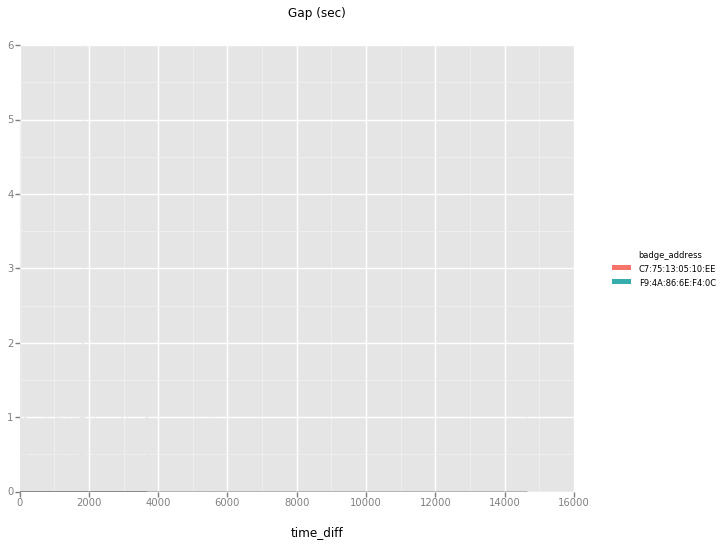

<ggplot: (8737709797837)>

In [18]:
p = ggplot(aes(x='time_diff', fill='badge_address'), data=gaps)
p + geom_histogram(binwidth=1)
p + geom_density(alpha=0.25) 
p + ggtitle("Gap (sec)")

Now, filter

In [19]:
gaps_and_first_rest = pd.merge(gaps.reset_index(),first_reset,how='left',on='badge_address')
print(gaps_and_first_rest.head())

                          datetime      badge_address     timestamp  \
0 2016-12-27 17:52:48.075000+00:00  C7:75:13:05:10:EE  1.482861e+09   
1 2016-12-27 21:19:30.506000+00:00  F9:4A:86:6E:F4:0C  1.482874e+09   
2 2016-12-27 22:32:51.126000+00:00  F9:4A:86:6E:F4:0C  1.482878e+09   
3 2016-12-28 04:14:15.760000+00:00  C7:75:13:05:10:EE  1.482898e+09   
4 2016-12-28 03:31:09.989000+00:00  F9:4A:86:6E:F4:0C  1.482896e+09   

   timestamp_lag  time_diff             first_reset_datetime  \
0   1.482861e+09      5.942 2017-01-03 03:51:17.736000+00:00   
1   1.482872e+09   1122.901 2016-12-30 14:45:36.636000+00:00   
2   1.482878e+09      5.915 2016-12-30 14:45:36.636000+00:00   
3   1.482895e+09   3658.995 2017-01-03 03:51:17.736000+00:00   
4   1.482895e+09   1037.447 2016-12-30 14:45:36.636000+00:00   

   first_reset_timestamp  
0           1.483415e+09  
1           1.483109e+09  
2           1.483109e+09  
3           1.483415e+09  
4           1.483109e+09  


In [20]:
gaps_before_first_reset = gaps_and_first_rest[gaps_and_first_rest['timestamp_lag'] < gaps_and_first_rest['first_reset_timestamp']]
gaps_before_first_reset

,datetime,badge_address,timestamp,timestamp_lag,time_diff,first_reset_datetime,first_reset_timestamp
0,2016-12-27 17:52:48.075000+00:00,C7:75:13:05:10:EE,1.482861e+09,1.482861e+09,5.942,2017-01-03 03:51:17.736000+00:00,1.483415e+09
1,2016-12-27 21:19:30.506000+00:00,F9:4A:86:6E:F4:0C,1.482874e+09,1.482872e+09,1122.901,2016-12-30 14:45:36.636000+00:00,1.483109e+09
2,2016-12-27 22:32:51.126000+00:00,F9:4A:86:6E:F4:0C,1.482878e+09,1.482878e+09,5.915,2016-12-30 14:45:36.636000+00:00,1.483109e+09
3,2016-12-28 04:14:15.760000+00:00,C7:75:13:05:10:EE,1.482898e+09,1.482895e+09,3658.995,2017-01-03 03:51:17.736000+00:00,1.483415e+09
4,2016-12-28 03:31:09.989000+00:00,F9:4A:86:6E:F4:0C,1.482896e+09,1.482895e+09,1037.447,2016-12-30 14:45:36.636000+00:00,1.483109e+09
5,2016-12-28 04:44:59.170000+00:00,F9:4A:86:6E:F4:0C,1.482900e+09,1.482900e+09,5.979,2016-12-30 14:45:36.636000+00:00,1.483109e+09
6,2016-12-28 23:56:03.527000+00:00,C7:75:13:05:10:EE,1.482969e+09,1.482968e+09,1860.914,2017-01-03 03:51:17.736000+00:00,1.483415e+09
7,2016-12-29 02:31:09.236000+00:00,C7:75:13:05:10:EE,1.482979e+09,1.482977e+09,1868.802,2017-01-03 03:51:17.736000+00:00,1.483415e+09
8,2016-12-29 13:12:06.471000+00:00,F9:4A:86:6E:F4:0C,1.483017e+09,1.483016e+09,1111.501,2016-12-30 14:45:36.636000+00:00,1.483109e+09
9,2016-12-29 14:25:32.836000+00:00,F9:4A:86:6E:F4:0C,1.483022e+09,1.483022e+09,5.963,2016-12-30 14:45:36.636000+00:00,1.483109e+09


In [21]:
print(len(gaps_before_first_reset))

27


In [22]:
gaps_before_first_reset[1:2].timestamp.map('{:.3f}'.format)

1    1482873570.506
Name: timestamp, dtype: object

In [23]:
gaps_before_first_reset[8:9].timestamp.map('{:.3f}'.format)

8    1483017126.471
Name: timestamp, dtype: object